In [1]:
import sys
sys.path.append("../")
from pathlib import Path

import numpy as np
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from train import Trainer, set_seed
from data import TrainDataset, Tokenizer, get_classified_tokenset
from type import (
    AugmentationConfig,
    StorageConfig,
    StepFuncConfig,
    DescriptionConfig,
    TokenizerConfig,
    DataLoaderConfig,
    SchedulerConfig,
    TrainerConfig,
    OptimizerConfig,
    SupConLossConfig,
    TanimotoLossConfig,
    SupConLossWithTanimotoScoreConfig
)
from train_fn import step_train, step_evaluate
from loss import SupConLossWithTanimotoScore, SupConLoss, TanimotoScoreLoss
from model import SiameseModel
from const import gnps

In [2]:
# load data
train_spectra = np.load(gnps.ORBITRAP_TRAIN_REF, allow_pickle=True)
unique_smiles = np.load(
    gnps.DIR / gnps.UNIQUE_SMILES,
    allow_pickle=True
)
print("load data success")

# tokenization
tokenizer_config = TokenizerConfig(
    max_len=100,
    show_progress_bar=True
)
tokenizer = Tokenizer(**tokenizer_config)
sequences = tokenizer.tokenize_sequence(train_spectra)
data, labels = get_classified_tokenset(unique_smiles, sequences)
np.save("./data.npy", data)
np.save("./labels.npy", labels)
print("finish the tokenize process")

load data success


classify the dataset: 100%|██████████| 122979/122979 [00:15<00:00, 7955.91it/s]


finish the tokenize process


In [3]:
data = np.load("./data.npy", allow_pickle=True).item()
labels = np.load("./labels.npy", allow_pickle=True)

In [4]:
seed = set_seed(42)

is_augment = True

augment_config = AugmentationConfig(
    prob=0.5,
    removal_max=0.2,
    removal_intensity=0.3,
    rate_intensity=0.15,
)

# dataset and dataloader
dataloader_config = DataLoaderConfig(
    batch_size=512,
    val_ratio=0.2
)

length = len(labels)
val_indices = np.random.choice(
    np.arange(length), 
    int(dataloader_config["val_ratio"] * length), 
    replace=False
)
val_keys = labels[val_indices]
train_keys = np.delete(labels, val_indices)

train_dataset = TrainDataset(
    data=data,
    keys=train_keys,
    n_views=2,
    is_augment=is_augment,
    augment_config=augment_config
)

val_dataset = TrainDataset(
    data=data,
    keys=val_keys,
    n_views=2
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=dataloader_config["batch_size"],
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=dataloader_config["batch_size"],
    shuffle=False
)

In [5]:
loss_type = "SupConWithTanimotoLoss"
model_backbone = "transformer"

In [6]:
# model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SiameseModel(
    512,
    16,
    4,
    512,
    512,
    feedward_activation="selu",
)
model = model.to(device)

# trainer
trainer_config = TrainerConfig(
    n_epoch=50,
    device=device,
    early_stop=20,
    show_progress_bar=True
)
# scheduler
n_step = trainer_config["n_epoch"] * len(train_dataloader)
scheduler_config = SchedulerConfig(
    warmup_steps=int(n_step * 0.1),
    total_steps=n_step
)

# loss
reduction = "mean"
tanimoto_score_path = "/data1/xp/data/GNPS/tanimoto_score.npy"
if loss_type == "SupConLoss":
    loss_config = SupConLossConfig(
        device=device,
        temperature=0.01,
        base_temperature=0.5,
        contrast_mode='all',
        reduction=reduction
    )
    criterion = SupConLoss(**loss_config)
elif loss_type == "TanimotoLoss":
    loss_config = TanimotoLossConfig(
        score_path=tanimoto_score_path,
        device=device,
        reduction=reduction
    )
    criterion = TanimotoScoreLoss(**loss_config)
elif loss_type == "SupConWithTanimotoLoss":
    loss_config = SupConLossWithTanimotoScoreConfig(
        alpha=30,
        score_path=tanimoto_score_path,
        device=device,
        temperature=0.05,
        contrast_mode="all",
        base_temperature=0.05,
        reduction=reduction
    )
    criterion = SupConLossWithTanimotoScore(**loss_config)

# optimizer
optimizer_config = OptimizerConfig(
    lr=7.5e-5,
    weight_decay=0.1
)
optimizer = AdamW(model.parameters(), **optimizer_config)

# desc
desc_config = DescriptionConfig(
    train="train, epoch={}, loss={:.4f}",
    val="validation, epoch={}, loss={:.4f}, save the model",
    end="model train end, best model loss={:.4f}"
)
# step func
stepfunc_config = StepFuncConfig(
    train=step_train,
    val=step_evaluate
)

suffix = ""
if is_augment:
    suffix = "-Augmentation"

# storage
model_dir = Path(f"./model/{model_backbone}-{loss_type}{suffix}")

model_dir.mkdir(parents=True, exist_ok=True)
storage_config = StorageConfig(
    model=model_dir / f"model.ckpt",
    lr=model_dir / f"lr.npy",
    step_loss=model_dir / f"step_loss.npy",
    loss=model_dir / "epoch_loss.npy",
    custom=model_dir / "custom_metric.npy"
)

In [7]:
# model train
torch.cuda.empty_cache()
trainer = Trainer(
    model,
    reduction,
    train_dataloader,
    val_dataloader,
    optimizer,
    criterion,
    device,
    stepfunc_config,
    desc_config,
    storage_config,
    trainer_config,
    scheduler_config
)

trainer.train()

Train: Epoch [1/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=2.0047]


train, epoch=1, loss=3.9431


Validation: Epoch [1/50]: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s, loss=3.3089]


validation, epoch=1, loss=3.3083, save the model


Train: Epoch [2/50]: 100%|██████████| 128/128 [00:52<00:00,  2.45it/s, loss=1.6038]


train, epoch=2, loss=2.1112


Validation: Epoch [2/50]: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s, loss=2.6779]


validation, epoch=2, loss=2.6040, save the model


Train: Epoch [3/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=1.1348]


train, epoch=3, loss=1.5595


Validation: Epoch [3/50]: 100%|██████████| 32/32 [00:04<00:00,  6.60it/s, loss=1.7916]


validation, epoch=3, loss=1.8450, save the model


Train: Epoch [4/50]: 100%|██████████| 128/128 [00:51<00:00,  2.49it/s, loss=0.8593]


train, epoch=4, loss=1.1844


Validation: Epoch [4/50]: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s, loss=1.3901]


validation, epoch=4, loss=1.3925, save the model


Train: Epoch [5/50]: 100%|██████████| 128/128 [00:52<00:00,  2.46it/s, loss=0.8236]


train, epoch=5, loss=0.9580


Validation: Epoch [5/50]: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s, loss=1.1148]


validation, epoch=5, loss=1.1964, save the model


Train: Epoch [6/50]: 100%|██████████| 128/128 [00:51<00:00,  2.51it/s, loss=0.6154]


train, epoch=6, loss=0.8271


Validation: Epoch [6/50]: 100%|██████████| 32/32 [00:04<00:00,  6.96it/s, loss=1.0440]


validation, epoch=6, loss=1.0953, save the model


Train: Epoch [7/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.6617]


train, epoch=7, loss=0.7293


Validation: Epoch [7/50]: 100%|██████████| 32/32 [00:04<00:00,  6.81it/s, loss=0.9258]


validation, epoch=7, loss=0.9904, save the model


Train: Epoch [8/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.5674]


train, epoch=8, loss=0.6480


Validation: Epoch [8/50]: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, loss=0.8955]


validation, epoch=8, loss=0.9275, save the model


Train: Epoch [9/50]: 100%|██████████| 128/128 [00:53<00:00,  2.39it/s, loss=0.5170]


train, epoch=9, loss=0.5958


Train: Epoch [10/50]: 100%|██████████| 128/128 [00:51<00:00,  2.47it/s, loss=0.4157]


train, epoch=10, loss=0.5579


Validation: Epoch [10/50]: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s, loss=0.9441]


validation, epoch=10, loss=0.8984, save the model


Train: Epoch [11/50]: 100%|██████████| 128/128 [00:52<00:00,  2.46it/s, loss=0.5002]


train, epoch=11, loss=0.5195


Validation: Epoch [11/50]: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s, loss=0.8467]


validation, epoch=11, loss=0.8851, save the model


Train: Epoch [12/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.3941]


train, epoch=12, loss=0.4915


Validation: Epoch [12/50]: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s, loss=0.8257]


validation, epoch=12, loss=0.8541, save the model


Train: Epoch [13/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.3726]


train, epoch=13, loss=0.4649


Validation: Epoch [13/50]: 100%|██████████| 32/32 [00:04<00:00,  6.78it/s, loss=0.8173]


validation, epoch=13, loss=0.8179, save the model


Train: Epoch [14/50]: 100%|██████████| 128/128 [00:51<00:00,  2.47it/s, loss=0.3739]


train, epoch=14, loss=0.4449


Train: Epoch [15/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.3727]


train, epoch=15, loss=0.4311


Validation: Epoch [15/50]: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s, loss=0.8321]


validation, epoch=15, loss=0.8138, save the model


Train: Epoch [16/50]: 100%|██████████| 128/128 [00:52<00:00,  2.46it/s, loss=0.3629]


train, epoch=16, loss=0.4135


Validation: Epoch [16/50]: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s, loss=0.8411]


validation, epoch=16, loss=0.7921, save the model


Train: Epoch [17/50]: 100%|██████████| 128/128 [00:52<00:00,  2.44it/s, loss=0.3021]


train, epoch=17, loss=0.3988


Validation: Epoch [17/50]: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s, loss=0.7738]


validation, epoch=17, loss=0.7804, save the model


Train: Epoch [18/50]: 100%|██████████| 128/128 [00:52<00:00,  2.42it/s, loss=0.3144]


train, epoch=18, loss=0.3894


Train: Epoch [19/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.3048]


train, epoch=19, loss=0.3779


Validation: Epoch [19/50]: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s, loss=0.7957]


validation, epoch=19, loss=0.7795, save the model


Train: Epoch [20/50]: 100%|██████████| 128/128 [00:52<00:00,  2.44it/s, loss=0.2815]


train, epoch=20, loss=0.3656


Validation: Epoch [20/50]: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s, loss=0.8124]


validation, epoch=20, loss=0.7755, save the model


Train: Epoch [21/50]: 100%|██████████| 128/128 [00:52<00:00,  2.45it/s, loss=0.3112]


train, epoch=21, loss=0.3556


Validation: Epoch [21/50]: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s, loss=0.8215]


validation, epoch=21, loss=0.7707, save the model


Train: Epoch [22/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.3321]


train, epoch=22, loss=0.3524


Validation: Epoch [22/50]: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s, loss=0.7685]


validation, epoch=22, loss=0.7483, save the model


Train: Epoch [23/50]: 100%|██████████| 128/128 [00:51<00:00,  2.50it/s, loss=0.2772]


train, epoch=23, loss=0.3447


Train: Epoch [24/50]: 100%|██████████| 128/128 [00:52<00:00,  2.42it/s, loss=0.2516]


train, epoch=24, loss=0.3401


Train: Epoch [25/50]: 100%|██████████| 128/128 [00:52<00:00,  2.46it/s, loss=0.2838]


train, epoch=25, loss=0.3310


Validation: Epoch [25/50]: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s, loss=0.6951]


validation, epoch=25, loss=0.7480, save the model


Train: Epoch [26/50]: 100%|██████████| 128/128 [00:51<00:00,  2.47it/s, loss=0.2810]


train, epoch=26, loss=0.3279


Train: Epoch [27/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.2881]


train, epoch=27, loss=0.3215


Train: Epoch [28/50]: 100%|██████████| 128/128 [00:51<00:00,  2.50it/s, loss=0.2913]


train, epoch=28, loss=0.3185


Train: Epoch [29/50]: 100%|██████████| 128/128 [00:52<00:00,  2.45it/s, loss=0.2640]


train, epoch=29, loss=0.3165


Train: Epoch [30/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.3067]


train, epoch=30, loss=0.3109


Train: Epoch [31/50]: 100%|██████████| 128/128 [00:51<00:00,  2.47it/s, loss=0.2439]


train, epoch=31, loss=0.3103


Validation: Epoch [31/50]: 100%|██████████| 32/32 [00:04<00:00,  6.71it/s, loss=0.7170]


validation, epoch=31, loss=0.7315, save the model


Train: Epoch [32/50]: 100%|██████████| 128/128 [00:52<00:00,  2.46it/s, loss=0.2529]


train, epoch=32, loss=0.3045


Train: Epoch [33/50]: 100%|██████████| 128/128 [00:50<00:00,  2.53it/s, loss=0.2181]


train, epoch=33, loss=0.3017


Train: Epoch [34/50]: 100%|██████████| 128/128 [00:51<00:00,  2.47it/s, loss=0.2562]


train, epoch=34, loss=0.3009


Validation: Epoch [34/50]: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s, loss=0.6619]


validation, epoch=34, loss=0.7250, save the model


Train: Epoch [35/50]: 100%|██████████| 128/128 [00:52<00:00,  2.42it/s, loss=0.2187]


train, epoch=35, loss=0.2960


Train: Epoch [36/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.2689]


train, epoch=36, loss=0.2932


Train: Epoch [37/50]: 100%|██████████| 128/128 [00:52<00:00,  2.44it/s, loss=0.2451]


train, epoch=37, loss=0.2927


Train: Epoch [38/50]: 100%|██████████| 128/128 [00:49<00:00,  2.59it/s, loss=0.2717]


train, epoch=38, loss=0.2931


Train: Epoch [39/50]: 100%|██████████| 128/128 [00:51<00:00,  2.49it/s, loss=0.2042]


train, epoch=39, loss=0.2914


Train: Epoch [40/50]: 100%|██████████| 128/128 [00:52<00:00,  2.44it/s, loss=0.2483]


train, epoch=40, loss=0.2900


Train: Epoch [41/50]: 100%|██████████| 128/128 [00:52<00:00,  2.45it/s, loss=0.2566]


train, epoch=41, loss=0.2881


Train: Epoch [42/50]: 100%|██████████| 128/128 [00:53<00:00,  2.41it/s, loss=0.2027]


train, epoch=42, loss=0.2878


Train: Epoch [43/50]: 100%|██████████| 128/128 [00:52<00:00,  2.45it/s, loss=0.2358]


train, epoch=43, loss=0.2846


Train: Epoch [44/50]: 100%|██████████| 128/128 [00:52<00:00,  2.46it/s, loss=0.2252]


train, epoch=44, loss=0.2846


Train: Epoch [45/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.2208]


train, epoch=45, loss=0.2898


Train: Epoch [46/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.2514]


train, epoch=46, loss=0.2796


Train: Epoch [47/50]: 100%|██████████| 128/128 [00:52<00:00,  2.43it/s, loss=0.2525]


train, epoch=47, loss=0.2829


Train: Epoch [48/50]: 100%|██████████| 128/128 [00:52<00:00,  2.44it/s, loss=0.2412]


train, epoch=48, loss=0.2861


Train: Epoch [49/50]: 100%|██████████| 128/128 [00:52<00:00,  2.46it/s, loss=0.2361]


train, epoch=49, loss=0.2843


Train: Epoch [50/50]: 100%|██████████| 128/128 [00:52<00:00,  2.45it/s, loss=0.2076]


train, epoch=50, loss=0.2819


Validation: Epoch [50/50]: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s, loss=0.6959]

best model saved in epoch 33
model train end, best model loss=0.7250
store train metrics


<Axes: >

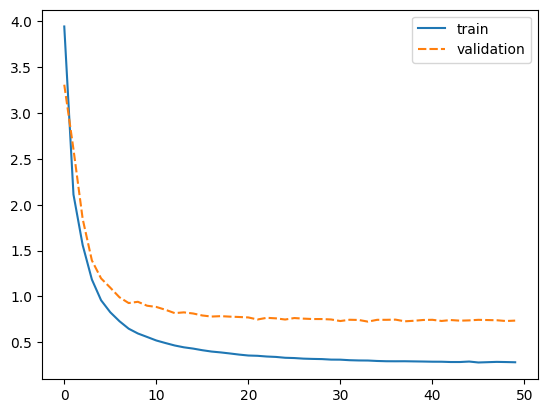

In [10]:
import seaborn as sns
import numpy as np

loss = np.load(model_dir / "epoch_loss.npy", allow_pickle=True).item()
sns.lineplot(loss)

<Axes: >

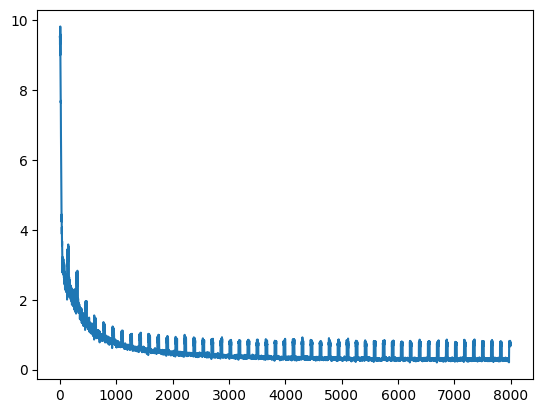

In [11]:
import seaborn as sns
import numpy as np

loss = np.load(model_dir / "step_loss.npy", allow_pickle=True)
sns.lineplot(loss)